# Detecção de Veículos com Visão Computacional Clássica

O objetivo final deste trabalho é identificar e contar modelos de veículos a partir de imagens de quaisquer câmeras de segurança espalhadas pelo mundo. Essa solução facilita e torna possível a geração de uma quantidade massiva de dados geográficos com relação a modelos de veículos que possuem um grande apelo comercial sob o interesse de empresas do ramo automotivo.

Este notebook apresenta uma tentativa de solução desse problema utilizando visão computacional clássica. Obviamente que sem o auxílio de redes neurais, não é possível criar um modelo universal de algoritmo que reconhece modelos de veículos. Entretanto, com algumas técnicas simples já é possível detectar a presença de objetos cujo comportamento pode ser avaliado e classificado com veículo seguindo algumas heurísticas básicas.

## 1. Importação de Bibliotecas

As bibliotecas utilizadas neste notebook são o numpy e o cv2.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## 2. Importação de Arquivo de Vídeo

Primeiramente é necessário importar um arquivo de vídeo que contenha imagens de uma rua ou avenida.

In [3]:
capture = cv2.VideoCapture('../videos/al.mkv')

## 3. Heurística de Classificação de Objetos

Os objetos identificados na imagem precisam passar por dois tipos de classificação.

Durante a identificação frame a frame de objetos, é necessário associar os objetos identificados no frame $n$ com os objetos do frame $n+1$. Para isso, é mantida uma lista de candidatos a veículos e cada novo objeto identificado passa pela função `insertCandidate` para ser associado a um objeto já existente ou considerado como um novo objeto.

In [4]:
candidates = [] # List of candidates to be a car

A função `insertCandidate` considera três thresholds nesse sentido. `width_threshold` e `height_threshold` representam a diferença percentual máxima da largura e altura dos objetos para serem considerados o mesmo, assim como `center_threshold`, que define uma distância máxima entre os centros dos objetos. Dessa forma, se um novo objeto identificado corresponder a um objeto já existente dentro desses limites, ele é considerado o mesmo, caso contrário, ele é adicionado na lista como um novo objeto.

A segunda etapa é identificar se um objeto é um veículo. O princípio de classificação de veículos é o de que se um objeto se comporta como um veículo, ele muito provavelmente é um. Nesse sentido, `count_threshold` representa a quantidade de vezes que um mesmo objeto precisa ser identificado na imagem para ser considerado um veículo.

In [5]:
'''
    Inserts a car candidate to the list

    @args
        - width_threshold, height_threshold: limit to width/height increase/decrease between frames
        - center_threshold: limit to center movement between frames
        - count_threshold: times to act like a car to be a car
'''
def insertCandidate(newCandidate, width_threshold=0.2, height_threshold=0.2, 
                    center_threshold=50, count_threshold=20):
    global candidates

    # Look for corresponding object
    for candidate in candidates:
        # If width, height and center correspond, it is the same object
        if newCandidate['width'] > candidate['width'] * (1-width_threshold) and \
           newCandidate['width'] < candidate['width'] * (1+width_threshold) and \
           newCandidate['height'] > candidate['height'] * (1-height_threshold) and \
           newCandidate['height'] < candidate['height'] * (1+height_threshold) and \
           np.linalg.norm(np.array(newCandidate['center'])-np.array(candidate['center'])) < center_threshold:
            candidate['count'] += 1 # Object identified again
            candidate['width'], candidate['height'] = newCandidate['width'], newCandidate['height']
            candidate['center'], candidate['t'] = newCandidate['center'], newCandidate['t']

            # If it moves like a car, it is a car
            if not candidate['car'] and candidate['count'] > count_threshold:
                candidate['car'] = True

            return candidate
    
    # If it doesn't correspond to any existant object, it is a new one
    candidates.append(newCandidate)
    return newCandidate

Um veículo não permanece nas imagens durante todo o vídeo e alguns objetos podem ter sido identificados poucas vezes por erros no algoritmo. Para removê-los da lista de candidatos a veículos, a função `removeOldCandidates` verifica se já fazem mais de `old_threshold` frames que um objeto não foi identificado nas imagens, se sim, ele é removido da lista.

In [6]:
'''
    Removes old candidates, that probably are not cars

    @args
        - old_threshold: Amount of time unidentified before being desconsidered

'''
def removeOldCandidates(t, old_threshold=10):
    global candidates
    
    candidates_to_remove = []
    for candidate in candidates:
        # If it is an old object, removes it
        if candidate['t'] < t - old_threshold:
            candidates_to_remove.append(candidate)
    for candidate in candidates_to_remove:
        candidates.remove(candidate)

## 4. Detecção de Objetos em Vídeo

Para detectar os veículos em imagens, é utilizado o algoritmo MOG2, que tenta distinguir objetos do plano de fundo. Esse algoritmo é basicamente um algoritmo de segmentação baseado nos artigos "Improved adaptive Gausian mixture model for background subtraction", de 2004, e "Efficient Adaptive Density Estimation per Image Pixel for the Task of Background Subtraction" de 2006, ambos de Z. Zivkovic.

In [7]:
# Background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

Entretanto, para melhorar os resultados desse algoritmo, é necessário aplicar algumas transformações na imagem original:

1. Conversão para escala de cinza
2. Aplicar blur
3. Dilatar
4. Fechamento com elipse

Ao possuir a máscara final, é utilizado o `findContours` para encontrar os objetos da imagem, assim, são considerados apenas objetos com tamanho maior que $60x60$.

Para cada objeto, é criado um novo candidato a ser um veículo e a função `insertCandidate` é responsável por associá-lo a um objeto já existente ou criar um novo. Além disso, a função `removeOldCandidates` é responsável por eliminar da lista veículos que já passaram pelo campo de visão da câmera ou que foram desconsiderados.

Antes de iniciar a análise dos frames, é preciso definir `t` (tempo) e uma função que retorna o centro de um objeto.

In [8]:
t = 0   # Time

# Returns the center of an object
def get_center(x, y, w, h):
    x1 = int(w/2)
    y1 = int(h/2)

    cx = x + x1
    cy = y + y1

    return cx, cy

Agora, é necessário executar diversas vezes a célula abaixo para visualizar os resultados do algoritmo.

Um quadrado de cor aleatória é desenhado a cada novo objeto encontrado, o ponto central é azul se o objeto ainda não tenha sido classificado como veículo e verde em caso afirmativo. Dessa forma, é possível visualizar a associação de objetos frame a frame e a classificação dos objetos como veículos.

Também é possível visualizar o resultado da máscara que remove o plano de fundo.

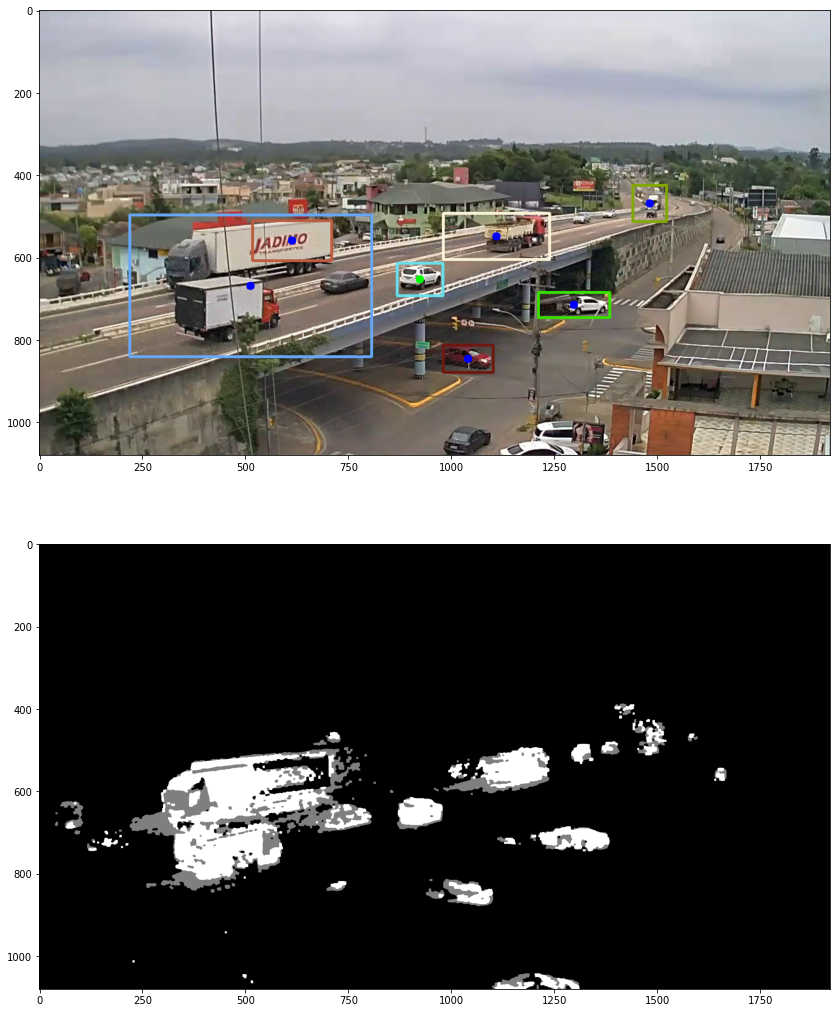

In [67]:
ret, frame = capture.read() # Read frame

# Change to gray
grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  

# Apply blur
blur = cv2.GaussianBlur(grey, (7, 7), 15)   
fgmask = fgbg.apply(blur)

# Dilate
dilated = cv2.dilate(fgmask, np.ones((5, 5)))

# Apply kernel two times
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
dilated = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
dilated = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)

# Find objects
border, h = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Analyze objects
for i, c in enumerate(border):
    x, y, w, h = cv2.boundingRect(c)

    # Minimum 60x60 size
    validate_border = (w >= 60) and (h >= 60)
    if not validate_border:
        continue

    # Get center
    center = get_center(x, y, w, h)

    # Create new candidate to be a car
    newCandidate = {
        'width': w,
        'height': h,
        'center': center,
        'count': 0,
        'car': False,
        't': t,
        # Random color
        'color': tuple(int(c) for c in np.random.choice(range(256), size=3))
    }
    
    # Insert candidate properly
    newCandidate = insertCandidate(newCandidate)

    # Draw candidate
    cv2.rectangle(frame, (x, y), (x+w, y+h), newCandidate['color'], 5)
    # If it is a car, center is green, otherwise is blue
    cv2.circle(frame, center, 10, (0, 255, 0) if newCandidate['car'] else (255, 0, 0), -1)

# Remove old candidates
removeOldCandidates(t)

fig, ax = plt.subplots(nrows=2, figsize=(32, 18))

# Show frame
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
ax[0].imshow(frame_rgb)
ax[1].imshow(dilated, 'gray')

t += 1